## Setup and Cleaning

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


In [2]:
battles = pd.read_csv('battles.csv')
character_deaths = pd.read_csv('character-deaths.csv')
character_predictions = pd.read_csv('character-predictions.csv')

In [3]:
# start with character_predictions as main df
df = character_predictions

# add calculated cols: num_books, culture, 
df.loc[:, "num_books"] = df[[x for x in df.columns if x.startswith("book")]].sum(axis = 1)

cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

def get_cult(value):
    value = value.lower()
    v = [k for (k, v) in cult.items() if value in v]
    return v[0] if len(v) > 0 else value.title()

df.loc[:, "culture"] = [get_cult(x) for x in df.culture.fillna("")]

# convert 'house' and 'name' to string
df['house'] = df['house'].astype(str)
df['name'] = df['name'].astype(str)

# add col to see if character's name also appears in the house name
name_check=[]

for i in range(len(df)):
    name_set = set(df.ix[i,'name'].split(' '))
    house_set = set(df.ix[i,'house'].split(' '))
    name_check.append(int(bool(name_set&house_set)))
    
df['name_in_house'] = name_check

In [4]:
# get rid of previous prediction information from source data; we're going to make our own predictions!
df.drop(['S.No','actual','pred','alive','plod'],axis=1,inplace=True)

In [5]:
# transform culture into dummy variables and append to dataframe
culture_dummies = pd.get_dummies(df.culture).iloc[:,1:]
df = pd.concat([df,culture_dummies],axis=1)

In [6]:
# add age groups

df['is_old'] = df['age'].apply(lambda x: 1 if x>70 else 0)
df['is_young'] = df['age'].apply(lambda x: 1 if x<18 else 0)
df['is_middle_aged'] = df['age'].apply(lambda x: 1 if x>=18 and x<=70 else 0)

## Data Exploration

In [7]:
def plot(cat):
    df.groupby(cat).isAlive.mean().plot(kind='bar')
    plt.ylabel('Percent Alive')
    plt.ylim([0.0, 1.0])
    plt.show()

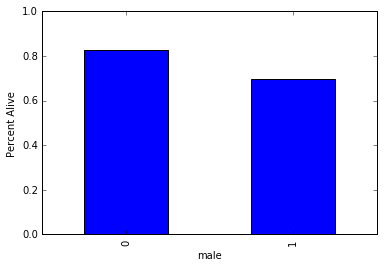

In [8]:
plot('male')

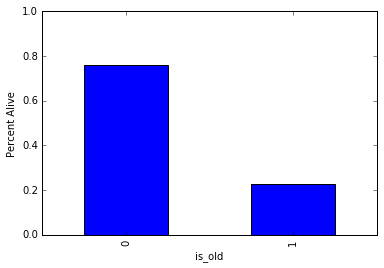

In [9]:
plot('is_old')

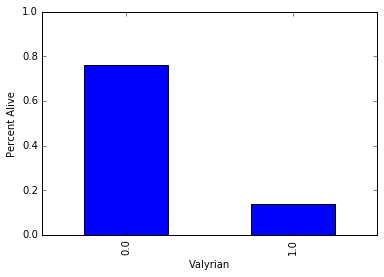

In [10]:
plot('Valyrian')

In [11]:
# popularity: https://docs.google.com/spreadsheets/d/1WQlsF_agiphO1TUYb0W8cLwd-OL4RYvTtFDq08mV0QI/edit?usp=sharing

## Train/Test/Split

In [12]:
# train/test/split used for models

feature_cols = ['male','book1','book2','book3','book4','book5','isMarried','isNoble','popularity','name_in_house',\
                'boolDeadRelations','is_old','is_young','is_middle_aged']+list(culture_dummies.columns.values)
X = df[feature_cols]
y = df.isAlive

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)

In [13]:
'''nar=[]
for i in range(40):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    nar.append(y_test.mean())

plt.plot(np.arange(40),nar)'''

'nar=[]\nfor i in range(40):\n    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)\n    nar.append(y_test.mean())\n\nplt.plot(np.arange(40),nar)'

## Null Accuracy Rate

In [14]:
# compute null accuracy rate
na_rate = y.mean()
print 'null accuracy rate: %s' %na_rate
print y_test.mean()

null accuracy rate: 0.745632065776
0.745379876797


## Metrics and Confusion Matrix

In [15]:
# initialize dictionaries to hold comparisons across models
accuracy_comparison = {}
auc_comparison = {}
sensitivity_comparison = {}
specificity_comparison = {}

# define  output

# confusion matrix
def plot_confusion_matrix(cm, order, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(order))
    plt.xticks(tick_marks, order, rotation=0)
    plt.yticks(tick_marks, order)
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def roc_auc():
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    print 'AUC: %s' %metrics.roc_auc_score(y_test, probs)

def c_val(model,cv=10,scoring='accuracy'):
    cv_score = cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    print 'cross_val_score: %s (cv=%s and scoring=%s)' %(cv_score,cv,scoring)
    return cv_score

def SCORE(model):
    print 'accuracy: %s' %metrics.accuracy_score(y_test, preds)
    print 'compared to null accuracy rate of: %s' %y_test.mean()
    cm = metrics.confusion_matrix(y_test, preds)
    plt.figure()
    plot_confusion_matrix(cm,['dead','alive'])
    
    sensitivity = 1.*cm[1,1]/sum(cm[1,:])
    print 'sensitivity (if alive, chance we predicted correctly): ' + str(sensitivity)

    specificity = 1.*cm[0,0]/sum(cm[0,:])
    print 'specificity (if dead, chance we predicted correctly): ' + str(specificity)
    roc_auc()

    c_val(model,10,'roc_auc')
    c_val(model,100,'roc_auc')
    c_val(model,10,'accuracy')
    c_val(model,100,'accuracy')
    
    accuracy_comparison[model_name] = c_val(model,100,'accuracy')
    auc_comparison[model_name] = c_val(model,100,'roc_auc')
    sensitivity_comparison[model_name] = sensitivity
    specificity_comparison[model_name] = specificity
    
'''
top left: predicted dead, actually died
bottom left: predicted dead, actually alive
top right: predicted alive, actually dead
bottom right: predicted alive, actually alive
'''



'\ntop left: predicted dead, actually died\nbottom left: predicted dead, actually alive\ntop right: predicted alive, actually dead\nbottom right: predicted alive, actually alive\n'

## Model 1: Logistic Regression
TODO: Normalize column values, cross validation, tune model, ROC/AUC

accuracy: 0.792607802875
compared to null accuracy rate of: 0.745379876797


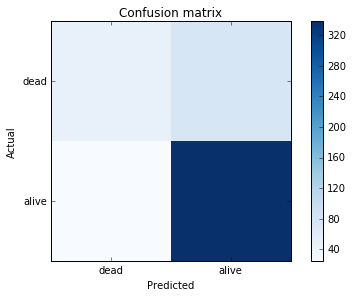

sensitivity (if alive, chance we predicted correctly): 0.931129476584
specificity (if dead, chance we predicted correctly): 0.387096774194


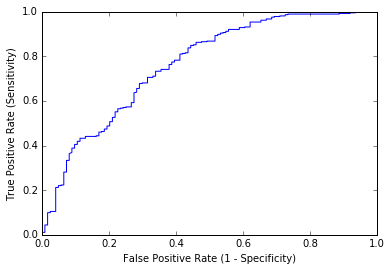

AUC: 0.76349640096
cross_val_score: 0.757565480609 (cv=10 and scoring=roc_auc)
cross_val_score: 0.766869047619 (cv=100 and scoring=roc_auc)
cross_val_score: 0.782100508721 (cv=10 and scoring=accuracy)
cross_val_score: 0.781997076023 (cv=100 and scoring=accuracy)
cross_val_score: 0.781997076023 (cv=100 and scoring=accuracy)
cross_val_score: 0.766869047619 (cv=100 and scoring=roc_auc)


In [16]:
# Model 1: Logistic Regression

model_name = 'logreg'
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
preds = logreg.predict(X_test)
probs = logreg.predict_proba(X_test)[:, 1]
SCORE(logreg)



## Model 2: Decision Tree / Random Forest

In [17]:
''' commenting out until needed since it is sloooow

# find the ideal number of trees to use

from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()

# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average accuracy for each value of n_estimators
scores = []

# use 5-fold cross-validation with each value of n_estimators
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    score = cross_val_score(rfreg, X, y, cv=5, scoring='roc_auc').mean()
    scores.append(score)


# plot n_estimators (x-axis) versus AUC (y-axis)
plt.plot(estimator_range, scores)
plt.xlabel('n_estimators')
plt.ylabel('AUC')

# show the best AUC and the corresponding n_estimators (num trees)
print sorted(zip(scores, estimator_range))[-1]
'''

" commenting out until needed since it is sloooow\n\n# find the ideal number of trees to use\n\nfrom sklearn.ensemble import RandomForestRegressor\nrfreg = RandomForestRegressor()\n\n# list of values to try for n_estimators\nestimator_range = range(10, 310, 10)\n\n# list to store the average accuracy for each value of n_estimators\nscores = []\n\n# use 5-fold cross-validation with each value of n_estimators\nfor estimator in estimator_range:\n    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)\n    score = cross_val_score(rfreg, X, y, cv=5, scoring='roc_auc').mean()\n    scores.append(score)\n\n\n# plot n_estimators (x-axis) versus AUC (y-axis)\nplt.plot(estimator_range, scores)\nplt.xlabel('n_estimators')\nplt.ylabel('AUC')\n\n# show the best AUC and the corresponding n_estimators (num trees)\nprint sorted(zip(scores, estimator_range))[-1]\n"

In [18]:
# set n_estimators
n = 250

In [19]:
''' commenting out until needed since it is sloooow
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=n, max_features=feature, random_state=1)
    score = cross_val_score(rfreg, X, y, cv=10, scoring='roc_auc')
    scores.append(np.mean(score))

# plot max_features (x-axis) versus AUC (y-axis)
plt.plot(feature_range, scores)
plt.xlabel('max_features')
plt.ylabel('AUC')

# show the best AUC and the corresponding max_features
print sorted(zip(scores, feature_range))[-1]
'''

" commenting out until needed since it is sloooow\n# list of values to try for max_features\nfeature_range = range(1, len(feature_cols)+1)\n\n# list to store the average RMSE for each value of max_features\nscores = []\n\n# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)\nfor feature in feature_range:\n    rfreg = RandomForestRegressor(n_estimators=n, max_features=feature, random_state=1)\n    score = cross_val_score(rfreg, X, y, cv=10, scoring='roc_auc')\n    scores.append(np.mean(score))\n\n# plot max_features (x-axis) versus AUC (y-axis)\nplt.plot(feature_range, scores)\nplt.xlabel('max_features')\nplt.ylabel('AUC')\n\n# show the best AUC and the corresponding max_features\nprint sorted(zip(scores, feature_range))[-1]\n"

In [20]:
# set max features
mf = 25

### Best Random Forest Model has 250 estimators and 25 max features

In [21]:
# fit best model
rfreg = RandomForestRegressor(n_estimators=n, max_features=mf, oob_score=True, random_state=1)
rfreg.fit(X, y)

# compute feature importances
rf_importance = pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance',ascending=False)
print rf_importance.head(25)

              feature  importance
8          popularity    0.350557
4               book4    0.085490
5               book5    0.044841
7             isNoble    0.039672
0                male    0.039564
2               book2    0.039156
9       name_in_house    0.039068
3               book3    0.037651
1               book1    0.036715
6           isMarried    0.027985
13     is_middle_aged    0.026377
11             is_old    0.025393
10  boolDeadRelations    0.025031
35           Northmen    0.025006
51           Valyrian    0.021170
12           is_young    0.019720
22          Free Folk    0.018930
25           Ironborn    0.016358
20            Dornish    0.007670
43           Rivermen    0.006404
23           Ghiscari    0.006401
40              Reach    0.005150
52          Westermen    0.005082
21           Dothraki    0.004328
47            Tyroshi    0.004310


In [22]:
# compute out of bag score
rfreg.oob_score_

0.23691368064874407

In [23]:
# create a new feature matrix that only includes important features
X_important = rfreg.transform(X, threshold=.01)
rf_feature_cols = list(rf_importance[rf_importance.importance>=.01]['feature'].values)

/Users/lucas/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [24]:
# get accuracy
rfreg = RandomForestRegressor(n_estimators=n, max_features=8)
rfreg.fit(X_train[rf_feature_cols], y_train)
probs = rfreg.predict(X_test[rf_feature_cols])
len(preds)

# Random Forest has no predict_proba, so we have to convert continuous to binary
preds = np.round(probs)

accuracy: 0.82135523614
compared to null accuracy rate of: 0.745379876797


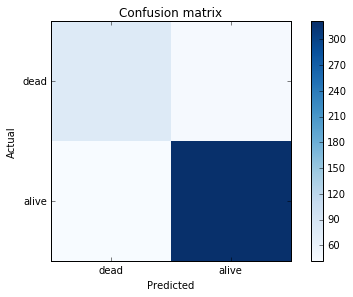

sensitivity (if alive, chance we predicted correctly): 0.884297520661
specificity (if dead, chance we predicted correctly): 0.637096774194


In [25]:
print 'accuracy: %s' %metrics.accuracy_score(y_test, preds)
print 'compared to null accuracy rate of: %s' %y_test.mean()
cm = metrics.confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm,['dead','alive'])

sensitivity = 1.*cm[1,1]/sum(cm[1,:])
print 'sensitivity (if alive, chance we predicted correctly): ' + str(sensitivity)

specificity = 1.*cm[0,0]/sum(cm[0,:])
print 'specificity (if dead, chance we predicted correctly): ' + str(specificity)

# add to comparison dicts
rfreg = RandomForestRegressor(n_estimators=n, max_features=8, random_state=1)
cross_val_score(rfreg, X_important, y, cv=10, scoring='roc_auc').mean()

model = 'random_forest'
accuracy_comparison[model] = metrics.accuracy_score(y_test, preds)
auc_comparison[model] = cross_val_score(rfreg, X_important, y, cv=10, scoring='roc_auc').mean()
sensitivity_comparison[model] = sensitivity
specificity_comparison[model] = specificity

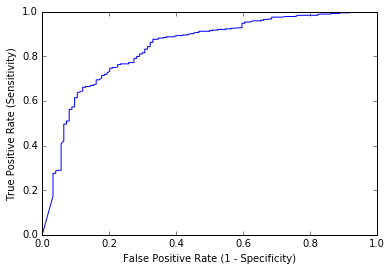

AUC: 0.839231760419


In [26]:
roc_auc()

## Model 3: Bayesian

accuracy: 0.792607802875
compared to null accuracy rate of: 0.745379876797


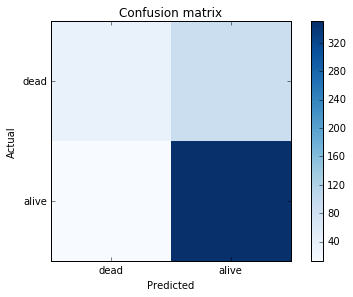

sensitivity (if alive, chance we predicted correctly): 0.964187327824
specificity (if dead, chance we predicted correctly): 0.290322580645


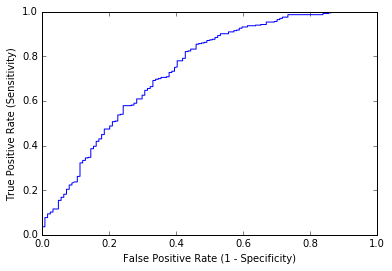

AUC: 0.74163556385
cross_val_score: 0.724628837496 (cv=10 and scoring=roc_auc)
cross_val_score: 0.731330952381 (cv=100 and scoring=roc_auc)
cross_val_score: 0.778489536973 (cv=10 and scoring=accuracy)
cross_val_score: 0.779871345029 (cv=100 and scoring=accuracy)
cross_val_score: 0.779871345029 (cv=100 and scoring=accuracy)
cross_val_score: 0.731330952381 (cv=100 and scoring=roc_auc)


In [27]:
model_name='bayesian'
nb = MultinomialNB()
nb.fit(X_train, y_train)
preds = nb.predict(X_test)
probs = nb.predict_proba(X_test)[:, 1]
SCORE(nb)

## Model Comparison

In [28]:
comparisons = [accuracy_comparison,auc_comparison,sensitivity_comparison,specificity_comparison]

accuracy_comparison: {'bayesian': 0.7798713450292396, 'random_forest': 0.82135523613963035, 'logreg': 0.78199707602339175}
auc_comparison: {'bayesian': 0.73133095238095236, 'random_forest': 0.79766885384630459, 'logreg': 0.76686904761904762}
sensitivity_comparison: {'bayesian': 0.9641873278236914, 'random_forest': 0.8842975206611571, 'logreg': 0.931129476584022}
specificity_comparison: {'bayesian': 0.2903225806451613, 'random_forest': 0.6370967741935484, 'logreg': 0.3870967741935484}


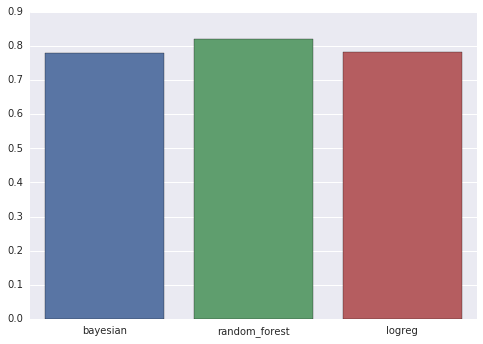

In [29]:
import seaborn as sns
print 'accuracy_comparison: ' + str(accuracy_comparison)
print 'auc_comparison: ' + str(auc_comparison)
print 'sensitivity_comparison: ' + str(sensitivity_comparison)
print 'specificity_comparison: ' + str(specificity_comparison)

sns.barplot(comparisons[0].keys(),comparisons[0].values())

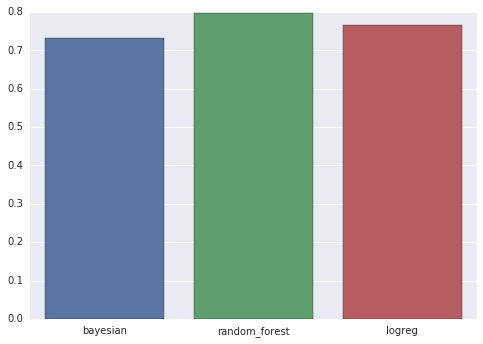

In [30]:
sns.barplot(comparisons[1].keys(),comparisons[1].values())

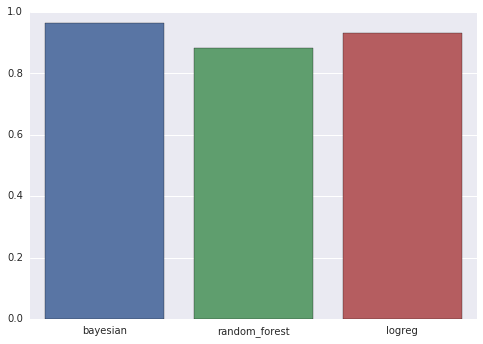

In [31]:
sns.barplot(comparisons[2].keys(),comparisons[2].values())

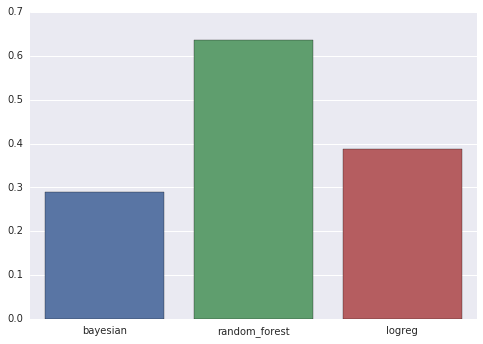

In [32]:
sns.barplot(comparisons[3].keys(),comparisons[3].values())

## Which Characters that Are Still Alive Have Highest Chance of Death?

In [33]:
# logreg prediction
df['likelihood_of_death'] = 1 - logreg.predict_proba(X)[:, 1]
df[df.isAlive==1].sort_values(by='likelihood_of_death',ascending=False)[['name','likelihood_of_death']].head(12)

,name,likelihood_of_death
909,Ardrian Celtigar,0.875462
1835,Tysha,0.839689
387,Bryen,0.835518
1,Walder Frey,0.828664
1677,Daenerys Targaryen,0.827858
1741,Jaime Lannister,0.807363
283,Aegon Targaryen (son of Baelon),0.728942
328,Ayrmidon,0.709589
172,Stannis Baratheon,0.696874
5,Tommen Baratheon,0.696874


In [34]:
# random forest prediction
rfreg = RandomForestRegressor(n_estimators=n, max_features=8)
rfreg.fit(X[rf_feature_cols], y)
preds = rfreg.predict(X[rf_feature_cols])

df['likelihood_of_death'] = 1 - preds
df[df.isAlive==1].sort_values(by='likelihood_of_death',ascending=False)[['name','likelihood_of_death']].head(30)

,name,likelihood_of_death
420,Collio Quaynis,0.693062
204,Toregg,0.672451
172,Stannis Baratheon,0.672292
5,Tommen Baratheon,0.672292
173,Steffon Varner,0.656979
44,Zei,0.639843
1488,Crawn,0.638600
1872,Parmen Crane,0.635872
266,Werlag,0.635284
791,Mother Mole,0.592905


## OLD CODE NOT IN USE

In [35]:
'''
def died(df):
    if np.isnan(df['Death Year']) and np.isnan(df['Book of Death']) and np.isnan(df['Death Chapter']):
        return False
    else:
        return True

character_deaths['died'] = character_deaths.apply(died,axis=1)
'''

"\ndef died(df):\n    if np.isnan(df['Death Year']) and np.isnan(df['Book of Death']) and np.isnan(df['Death Chapter']):\n        return False\n    else:\n        return True\n\ncharacter_deaths['died'] = character_deaths.apply(died,axis=1)\n"